In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation

from IPython.display import HTML

# Set the limit to, for example, 100 MB
plt.rcParams['animation.embed_limit'] = 100
%matplotlib inline

import numpy as np
import random
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
class Environment:
    def __init__(self, size, max_capacity=4, agent_vision_range=(1, 6), agent_metabolism_range=(1, 4), enable_seasons=True):
        self.size = size
        self.enable_seasons = enable_seasons  # Control seasonal effects
        self.eco_crisis = []  # Store active ecological evils here
        self.active_diseases = []  # Initialize the list for active diseases
        
        self.max_capacity = max_capacity
        self.agent_vision_range = agent_vision_range
        self.agent_metabolism_range = agent_metabolism_range
        
        self.northern_mountain_cells = []  # Stores coordinates of cells in the northern mountain
        self.southern_mountain_cells = []  # Stores coordinates of cells in the southern mountain
        
        # Initialization of other attributes...
        self.grid = np.zeros(size, dtype=int)
        self.max_sugar_capacity = np.zeros(size, dtype=int)
        self.initialize_sugar_capacity(max_capacity)
        self.initialize_sugar()
        self.agents = []
        self.occupied_locations = set()
        self.history = [np.copy(self.grid)]
        self.agents_history = []  # Make sure this is initialized here
        self.data_collector = DataCollection()
        
        # Season tracking
        self.current_step = 0
        self.season_length = 50
        # Initially, northern half starts in summer, southern in winter
        self.northern_summer = True
        
        # Initialize counters
        self.replacements = 0
        self.deaths_due_to_age = 0
        self.deaths_due_to_starvation = 0

    def initialize_sugar_capacity(self, max_capacity):
        """Defines the maximum sugar capacity for each cell, including mountains."""
        # Initialize all cells with a default capacity
        self.max_sugar_capacity.fill(0)  # Assuming wasteland has minimal sugar

        # Define peaks for the sugar mountains
        peak1 = (int(self.size[0] / 4), int(self.size[1] / 4))  # Northern peak
        peak2 = (int(3 * self.size[0] / 4), int(3 * self.size[1] / 4))  # Southern peak

        # Define the sugar mountains
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                distance1 = np.sqrt((i - peak1[0])**2 + (j - peak1[1])**2)
                distance2 = np.sqrt((i - peak2[0])**2 + (j - peak2[1])**2)

                # Determine if the cell is closer to the northern or southern peak
                if distance1 < distance2:
                    self.northern_mountain_cells.append((i, j))
                else:
                    self.southern_mountain_cells.append((i, j))

                # The further from the peak, the lower the maximum capacity
                capacity1 = max(max_capacity - int(distance1 / 3), 0)
                capacity2 = max(max_capacity - int(distance2 / 3), 0)

                # Assign the higher of the two capacities, capped at max_capacity
                self.max_sugar_capacity[i, j] = min(max(capacity1, capacity2), max_capacity)

    def initialize_sugar(self):
        """Initializes the grid with sugar according to max capacity."""
        self.grid = np.copy(self.max_sugar_capacity)  # Start with the max capacity as initial sugar levels

    def grow_sugar(self):
        """Simulates the regrowth of sugar on the grid, respecting each cell's max capacity."""
        # Reset grid for non-seasonal growth or inactive mountain areas
        self.grid = np.zeros(self.size, dtype=int)  # Resetting to zero if you want to simulate 'dying off'

        severity = 0  # Default to no crisis effect if none are active
        for evil in self.eco_crisis:
            if evil.active:
                severity = max(severity, evil.severity)  # Assume the worst severity applies

        """
        Simulates the regrowth of sugar on the grid, respecting each cell's max capacity and considering seasonality.
        Each cell can grow by 1 unit per step up to its adjusted (seasonal) maximum capacity.
        """    
        if self.enable_seasons:
            active_mountain_cells = self.northern_mountain_cells if self.northern_summer else self.southern_mountain_cells
            for x, y in active_mountain_cells:
                # Ensure the adjusted max sugar capacity doesn't drop below zero
                adjusted_max_capacity = max(self.max_sugar_capacity[y, x] - severity, 0)
                self.grid[y, x] = min(self.grid[y, x] + 4, adjusted_max_capacity)
        else:
            for y in range(self.size[1]):
                for x in range(self.size[0]):
                    # Ensure the adjusted max sugar capacity doesn't drop below zero
                    adjusted_max_capacity = max(self.max_sugar_capacity[y, x] - severity, 0)
                    self.grid[y, x] = min(self.grid[y, x] + 4, adjusted_max_capacity)
        
    def switch_seasons(self):
        if self.enable_seasons and self.current_step % self.season_length == 0:
            self.northern_summer = not self.northern_summer

    def update_eco_crisis(self):
        """Updates the status of all active ecological evils."""
        for crisis in list(self.eco_crisis):  # Use a copy of the list for safe modification
            if crisis.active:
                crisis.duration -= 1
                if crisis.duration <= 0:
                    crisis.deactivate()
                    self.eco_crisis.remove(crisis)
    
    def trigger_crisis(self, crisis):
        """Activates and adds an evil to the environment."""
        crisis.activate()
        self.eco_crisis.append(crisis)
    
    def update_diseases(self):
        """Updates the status of all active diseases."""
        for disease in list(self.active_diseases):
            if disease.active:
                disease.update(self)
                if disease.is_over():
                    disease.deactivate()
                    self.active_diseases.remove(disease)

    def trigger_disease(self, disease):
        """Activates a disease and initially infects a random agent if possible."""
        disease.activate()
        if disease.active:  # Only proceed if the disease is successfully activated
            self.active_diseases.append(disease)
            if self.agents:  # Ensure there are agents to infect
                initial_infected_agent = random.choice(self.agents)
                initial_infected_agent.infect(disease.severity, disease.duration)
    
    def capture_agents_initial_positions(self):
        """Captures the initial positions of all agents."""
        # Make sure this method is called after all agents are added
        self.agents_history.append([(agent.location) for agent in self.agents])
        # Make sure to call capture_agents_initial_positions() after agents are added and before the simulation starts

    def add_agent(self, agent):
        self.agents.append(agent)
        self.occupied_locations.add(agent.location)

    def remove_agent(self, agent):
        """Removes an agent from the simulation."""
        self.agents.remove(agent)
        self.occupied_locations.discard(agent.location)

    def is_occupied(self, location):
        """Checks if a location is occupied by an agent."""
        return location in self.occupied_locations

    def move_agent(self, agent, new_location):
        """Moves an agent to a new location within the grid."""
        self.occupied_locations.discard(agent.location)
        agent.location = new_location
        self.occupied_locations.add(new_location)

    def harvest_sugar(self, location):
        """Allows an agent to harvest sugar from its current location."""
        sugar = self.grid[location]
        self.grid[location] = 0
        return sugar

    def generate_random_unoccupied_location(self):
        """Finds a random unoccupied location within the environment."""
        while True:
            location = (np.random.randint(0, self.size[0]), np.random.randint(0, self.size[1]))
            if not self.is_occupied(location):
                return location
    
    def find_adjacent_unoccupied_location(self, location):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right
        random.shuffle(directions)  # Randomize directions to avoid bias
        for dx, dy in directions:
            new_x = (location[0] + dx) % self.size[0]
            new_y = (location[1] + dy) % self.size[1]
            new_location = (new_x, new_y)
            if not self.is_occupied(new_location):
                return new_location
        return None  # No unoccupied adjacent locations available
    
    def get_von_neumann_neighbors(self, location):
        """Returns the Von Neumann neighbors (up, down, left, right) of a given location."""
        x, y = location
        neighbors = []
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right
        for dx, dy in directions:
            nx, ny = (x + dx) % self.size[0], (y + dy) % self.size[1]
            if self.is_occupied((nx, ny)):
                neighbor = self.get_agent_at((nx, ny))
                if neighbor:
                    neighbors.append(neighbor)
        return neighbors

    def get_agent_at(self, location):
        """Returns the agent at the specified location, if any."""
        for agent in self.agents:
            if agent.location == location:
                return agent
        return None
    
    def step(self):
        """Advances the simulation by one step, including managing eco crises and diseases."""
        self.current_step += 1
        self.switch_seasons()
        self.update_eco_crisis()
        self.update_diseases()  # Make sure diseases are updated each step
        self.grow_sugar()

        random.shuffle(self.agents)

        for agent in list(self.agents):
            if not agent.alive:
                continue  # Skip dead agents for processing
            
            agent_initial_sugar = agent.sugar
            agent.step(self)  # Internal agent state management including disease effects

            if agent.sugar < 1 and agent_initial_sugar > 0:
                self.deaths_due_to_starvation += 1
            if agent.age > agent.max_age:
                self.deaths_due_to_age += 1

        self.update_visualization_and_data()

    def update_visualization_and_data(self):
        """Updates the state of the grid and agents for visualization and collects data."""
        self.history.append(np.copy(self.grid))
        self.agents_history.append([(agent.location) for agent in self.agents])

        # Filter for living agents to pass to data collection
        living_agents = [agent for agent in self.agents if agent.alive]
        self.data_collector.update(living_agents, self.current_step, self.replacements,
                                   self.deaths_due_to_age, self.deaths_due_to_starvation)

In [3]:
class Agent:
    def __init__(self, location, sugar=20, metabolism=1, vision=2, max_age=100, age=0):
        self.location = location
        self.sugar = sugar
        self.original_metabolism = metabolism  # Store original metabolism for disease effect
        self.metabolism = max(1, metabolism)
        self.vision = max(1, vision)
        self.age = age
        self.max_age = max_age
        self.alive = True  # Initialize the agent as alive
        self.is_infected = False
        self.infection_duration = 0
        self.disease_severity = 0
        self.is_immune = False  # Track immunity status
        self.just_infected = False  # Track if just infected in the current step
        self.just_recovered = False  # Track if just recovered in the current step
        self.death_cause = None  # Initialize with None

    def infect(self, severity, duration):
        if severity > 0 and duration > 0 and not self.is_immune and not self.is_infected:
            self.is_infected = True
            self.disease_severity = severity
            self.infection_duration = duration
            self.just_infected = True  # Mark as just infected
            self.adjust_metabolism()

    def adjust_metabolism(self):
        if self.is_infected:
            self.metabolism = 4 * self.original_metabolism

    def manage_disease(self):
        if self.is_infected:
            self.infection_duration -= 1
            if self.infection_duration <= 0:
                self.recover()

    def recover(self):
        self.is_infected = False
        self.just_recovered = True  # Mark as just recovered
        self.reset_metabolism()
        self.is_immune = True  # Grant immunity after recovery

    def reset_metabolism(self):
        self.metabolism = self.original_metabolism
        
    def check_and_infect_neighbors(self, neighbors, severity):
        """Check neighboring agents and potentially infect them based on disease severity."""
        if self.is_infected:  # Only spread the disease if this agent is infected
            for neighbor in neighbors:
                if not neighbor.is_immune and not neighbor.is_infected:
                    infection_chance = random.random()
                    if infection_chance < severity:
                        neighbor.infect(severity, self.infection_duration)
                else:
                    status = 'immune' if neighbor.is_immune else 'already infected'
                    # This else block now does nothing with 'status', but you can use it for debugging if needed
                    
    def look_around(self, environment):
        """
        Agent decides where to move based on the surrounding sugar.
        """
        best_sugar_level = -1
        best_location = self.location

        # Explore surrounding cells within vision
        for dx in range(-self.vision, self.vision + 1):
            for dy in range(-self.vision, self.vision + 1):
                if dx == 0 and dy == 0:
                    continue  # Skip the agent's current location

                # Calculate the target location, considering wrap-around
                target_x = (self.location[0] + dx) % environment.size[0]
                target_y = (self.location[1] + dy) % environment.size[1]
                target_location = (target_x, target_y)

                # Ensure the target location is not occupied and within the grid
                if not environment.is_occupied(target_location):
                    sugar_level = environment.grid[target_location]
                    if sugar_level > best_sugar_level:
                        best_sugar_level = sugar_level
                        best_location = target_location

        return best_location

    def move(self, environment, new_location):
        """
        Moves the agent to a new location.
        """
        environment.move_agent(self, new_location)

    def harvest(self, environment):
        """
        Harvests sugar from the current location.
        """
        self.sugar += environment.harvest_sugar(self.location)

    def step(self, environment):
        if not self.alive:  # Skip processing for dead agents
            return

        # Reset infection and recovery markers at the beginning of each step
        self.just_infected = False
        self.just_recovered = False

        # Aging and checking for natural death due to old age
        self.age += 1
        if self.age > self.max_age:
            self.alive = False
            self.death_cause = 'age'
            environment.remove_agent(self)
            return

        # Disease management within the step function
        if self.is_infected:
            self.manage_disease()
            if not self.alive:  # Check if the disease has led to death
                self.death_cause = 'disease'

        # Check for death due to running out of sugar
        if self.sugar <= 0:
            self.alive = False
            self.death_cause = 'starvation'
            environment.remove_agent(self)
            return

        # Movement and harvesting if alive
        if self.alive:
            new_location = self.look_around(environment)
            if new_location != self.location:
                self.move(environment, new_location)
            self.harvest(environment)

        # Subtract metabolism and check for death due to starvation
        self.sugar -= self.metabolism
        if self.sugar <= 0:
            self.alive = False
            self.death_cause = 'starvation'
            environment.remove_agent(self)
            return

        # Reproduction attempt only if still alive and conditions are met
        if self.alive:
            self.try_to_reproduce(environment)

    def try_to_reproduce(self, environment):
        # Set different sugar thresholds based on infection status
        sugar_threshold = 99 if self.is_infected else 49

        if self.age > 11 and self.age < 51 and self.sugar > sugar_threshold:
            new_location = environment.find_adjacent_unoccupied_location(self.location)
            if new_location:
                offspring = self.reproduce(new_location, environment)
                if offspring:  # Check if reproduction was successful
                    environment.add_agent(offspring)

    def reproduce(self, new_location, environment):
        # Adjust the sugar cost and offspring's sugar based on infection status
        if self.is_infected:
            reproduction_sugar_cost = int(0.75 * self.sugar)
            offspring_sugar = self.sugar // 10
        else:
            reproduction_sugar_cost = self.sugar // 2
            offspring_sugar = self.sugar // 5

        # Only proceed with reproduction if there's enough sugar
        if self.sugar > reproduction_sugar_cost:
            self.sugar -= reproduction_sugar_cost  # Parent loses sugar based on infection status

            # Define specific mutation functions for each attribute
            mutate_metabolism = lambda x: max(1, x + random.choice([-1, 0, 1]))
            mutate_vision = lambda x: max(1, x + random.choice([-2, 0, 2]))
            mutate_max_age = lambda x: x + random.choice([-5, 0, 5])

            # Apply these mutations to create offspring
            offspring = Agent(
                    location=new_location,
                    sugar=offspring_sugar,
                    metabolism=mutate_metabolism(self.metabolism),
                    vision=mutate_vision(self.vision),
                    max_age=mutate_max_age(self.max_age),
                    age=0  # Newborn starts at age 0
            )
            return offspring
        else:
            # Not enough sugar to reproduce, return None or similar to indicate failure
            return None

In [4]:
class EcoCrisis:
    def __init__(self, severity=0, duration=0, frequency=1):
        self.severity = severity
        self.duration = duration
        self.active = False  # Track whether the evil is currently active

    def activate(self):
        if self.severity > 0 and self.duration > 0:
            self.active = True
            # print(f"Crisis activated with severity {self.severity} and duration {self.duration}")
        else:
            # print("Crisis parameters set to zero, not activating disease.")
            pass

    def deactivate(self):
        self.active = False  # Mark the evil as inactive

    def apply_effect(self, environment):
        """Apply the effect to the environment; specifics should be implemented in subclasses."""
        pass

In [5]:
class Disease:
    def __init__(self, severity=0, duration=0, frequency=1):
        self.severity = severity
        self.duration = duration
        self.active = False

    def activate(self):
        if self.severity > 0 and self.duration > 0:
            self.active = True
            # print(f"Disease activated with severity {self.severity} and duration {self.duration}")
        else:
            # print("Disease parameters set to zero, not activating disease.")
            pass

    def deactivate(self):
        self.active = False

    def update(self, environment):
        """Update the disease status and apply effects to the environment."""
        if not self.active or self.duration <= 0:
            return  # Skip updating if the disease is not active or the duration has expired

        # Apply effects such as spreading the disease to agents
        for agent in environment.agents:
            if agent.is_infected:
                neighbors = environment.get_von_neumann_neighbors(agent.location)
                agent.check_and_infect_neighbors(neighbors, self.severity)

        # Decrement the duration only if the disease is active
        self.duration -= 1

    def is_over(self):
        """Check if the disease's active period has ended."""
        return self.duration <= 0

In [6]:
class DataCollection:
    def __init__(self):
        self.data = {}

    def update(self, agents, timestep, config_id, replacements=0, deaths_due_to_age=0, deaths_due_to_starvation=0):
        if config_id not in self.data:
            self.data[config_id] = {
                'population_data': pd.DataFrame(columns=['Timestep', 'Population']),
                'wealth_data': pd.DataFrame(columns=['Timestep', 'Wealth']),
                'age_distribution': pd.DataFrame(columns=['Timestep', 'Age', 'Count']),
                'metabolism_data': pd.DataFrame(columns=['Timestep', 'Metabolism']),
                'vision_data': pd.DataFrame(columns=['Timestep', 'Vision']),
                'infection_data': pd.DataFrame(columns=['Timestep', 'Infections', 'Recoveries']),
                'death_causes': pd.DataFrame(columns=['Timestep', 'AgeDeaths', 'StarvationDeaths', 'DiseaseDeaths', 'replacements'])
            }

        self.update_population(agents, timestep, config_id)
        self.update_wealth(agents, timestep, config_id)
        self.update_age_distribution(agents, timestep, config_id)
        self.update_metabolism(agents, timestep, config_id)
        self.update_vision(agents, timestep, config_id)
        self.update_infections(agents, timestep, config_id)
        self.update_deaths(agents, timestep, config_id, deaths_due_to_age, deaths_due_to_starvation, replacements)

    def update_population(self, agents, timestep, config_id):
        population_size = len(agents)
        self.data[config_id]['population_data'] = pd.concat(
            [self.data[config_id]['population_data'], pd.DataFrame({'Timestep': [timestep], 'Population': [population_size]})],
            ignore_index=True
        )

    def update_wealth(self, agents, timestep, config_id):
        wealth_values = [agent.sugar for agent in agents]
        wealth_df = pd.DataFrame({'Timestep': [timestep] * len(wealth_values), 'Wealth': wealth_values})
        self.data[config_id]['wealth_data'] = pd.concat([self.data[config_id]['wealth_data'], wealth_df], ignore_index=True)

    def update_age_distribution(self, agents, timestep, config_id):
        # Create a DataFrame for the current timestep
        age_data = pd.DataFrame([agent.age for agent in agents], columns=['Age'])
        age_data['Count'] = 1  # Each entry counts once
        age_data = age_data.groupby('Age').sum().reset_index()  # Summing counts per age
        age_data['Timestep'] = timestep  # Add timestep information

        # Ensure all ages from 0 to max_age are included after each update
        all_ages = pd.DataFrame({'Age': range(101)})  # Assuming max_age is a known constant
        all_ages = all_ages.merge(age_data, on='Age', how='left').fillna(0)  # Merge and fill NA with 0
        all_ages['Count'] = pd.to_numeric(all_ages['Count'], downcast='integer')  # Explicitly downcast to integer

        # Concatenate to the existing DataFrame, checking for empty or all-NA columns first
        new_data = all_ages[['Timestep', 'Age', 'Count']]
        if new_data.isnull().all(axis=0).any():
            new_data = new_data.dropna(axis=1, how='all')  # Drop columns that are entirely NA

        if config_id not in self.data:
            self.data[config_id] = {'age_distribution': new_data}
        else:
            self.data[config_id]['age_distribution'] = pd.concat([self.data[config_id]['age_distribution'], new_data])

        self.data[config_id]['age_distribution']['Count'] = self.data[config_id]['age_distribution']['Count'].astype(int)

    def update_metabolism(self, agents, timestep, config_id):
        metabolism_values = [agent.metabolism for agent in agents]
        metabolism_df = pd.DataFrame({'Timestep': [timestep] * len(metabolism_values), 'Metabolism': metabolism_values})
        self.data[config_id]['metabolism_data'] = pd.concat([self.data[config_id]['metabolism_data'], metabolism_df], ignore_index=True)

    def update_vision(self, agents, timestep, config_id):
        vision_values = [agent.vision for agent in agents]
        vision_df = pd.DataFrame({'Timestep': [timestep] * len(vision_values), 'Vision': vision_values})
        self.data[config_id]['vision_data'] = pd.concat([self.data[config_id]['vision_data'], vision_df], ignore_index=True)

    def update_infections(self, agents, timestep, config_id):
        infections = sum([1 for agent in agents if agent.just_infected])
        recoveries = sum([1 for agent in agents if agent.just_recovered])
        infection_df = pd.DataFrame({'Timestep': [timestep], 'Infections': [infections], 'Recoveries': [recoveries]})
        self.data[config_id]['infection_data'] = pd.concat([self.data[config_id]['infection_data'], infection_df], ignore_index=True)

    def update_deaths(self, agents, timestep, config_id, deaths_due_to_age, deaths_due_to_starvation, replacements):
        deaths_due_to_disease = sum(1 for agent in agents if agent.death_cause == 'disease')
        deaths_df = pd.DataFrame({
            'Timestep': [timestep],
            'AgeDeaths': [deaths_due_to_age],
            'StarvationDeaths': [deaths_due_to_starvation],
            'DiseaseDeaths': [deaths_due_to_disease],
            'Replacements': [replacements]
        })
        self.data[config_id]['death_causes'] = pd.concat([self.data[config_id]['death_causes'], deaths_df], ignore_index=True)

In [7]:
class Visualization:
    def __init__(self, environment):
        self.environment = environment
        self.fig, self.ax = plt.subplots()

        # Updated colormap with an even lighter shade of brown for the wasteland
        self.cmap = mcolors.ListedColormap(['#eae2d2', '#ccffcc', '#99ff99', '#66cc66', '#339933', '#006600'])
        self.bounds = [0, 1, 2, 3, 4, 5]  # Define boundaries for sugar levels
        self.norm = mcolors.BoundaryNorm(self.bounds, self.cmap.N)

    def visualize_state(self, step=None):
        self.ax.clear()
        grid_state = self.environment.grid if step is None else self.environment.history[step]
        im = self.ax.imshow(grid_state, cmap=self.cmap, norm=self.norm, interpolation='nearest')
        # Annotate cells with their sugar level
        for (j, i), label in np.ndenumerate(grid_state):
            self.ax.text(i, j, label, ha='center', va='center', color='black')
        plt.show()
        
        """def visualize_state(self, step=None):
        Visualizes the simulation state at a specific step, including agents.
        # Clear previous visualization
        self.ax.clear()
        
        # Determine grid state
        grid_state = self.environment.grid if step is None else self.environment.history[step]
        self.ax.imshow(grid_state, cmap=self.cmap, interpolation='nearest')
        
        # Overlay agents as red dots
        if step is None:
            agents = self.environment.agents
        else:
            # Assuming you have a way to track agents' positions over time
            agents = self.environment.agents_history[step]  # This needs to be implemented
        for agent in agents:
            self.ax.plot(agent.location[1], agent.location[0], 'ro', markersize=5)
        
        title = 'Current Grid State' if step is None else f'Grid State at Step {step}'
        self.ax.set_title(title)
        self.ax.set_xticks([])  # Hide x ticks
        self.ax.set_yticks([])  # Hide y ticks
        plt.show()"""

    def animate_simulation(self, interval=200):
        """
        Animates the simulation using stored states, showing agents as red dots, and annotates sugar levels.
        """
        def update(frame):
            self.ax.clear()  # Clear previous frame drawings
            grid_state = self.environment.history[frame]  # Get the grid state for the current frame
            im = self.ax.imshow(grid_state, cmap=self.cmap, norm=self.norm, interpolation='nearest')
            
            # Remove ticks
            self.ax.set_xticks([])
            self.ax.set_yticks([])
            
            # Set title
            self.ax.set_title(f'Sugarscape Simulation - Step {frame}')
            
            # Annotate each cell with its sugar level
            for (j, i), value in np.ndenumerate(grid_state):
                self.ax.text(i, j, str(value), ha='center', va='center', fontsize=6, color='black')

            # Overlay agents as red dots, correctly handling agent locations as tuples
            agents_locations = self.environment.agents_history[frame]  # Directly tuples of locations
            for agent_location in agents_locations:
                self.ax.plot(agent_location[1], agent_location[0], 'ro', markersize=5)

        # Setup animation
        frames = len(self.environment.history)  # Total number of frames in the animation
        anim = FuncAnimation(self.fig, update, frames=frames, interval=interval, repeat=False)
        plt.close(self.fig)  # Prevents duplicate display in notebooks
        return anim
        
    '''def animate_simulation(self, interval=200):
        """
        Animates the simulation using stored states, showing agents as red dots, starting from step 0.
        """
        def update(frame):
            self.ax.clear()
            grid_state = self.environment.history[frame]
            self.ax.imshow(grid_state, cmap=self.cmap, interpolation='nearest')
            self.ax.set_xticks([])
            self.ax.set_yticks([])
            self.ax.set_title(f'Sugarscape Simulation - Step {frame}')

            # Overlay agents as red dots, correctly handling agent locations as tuples
            agents_locations = self.environment.agents_history[frame]  # Now directly tuples of locations
            for agent_location in agents_locations:
                self.ax.plot(agent_location[1], agent_location[0], 'ro', markersize=5)

        frames = len(self.environment.history)
        anim = FuncAnimation(self.fig, update, frames=frames, interval=interval, repeat=False)
        plt.close(self.fig)  # Prevents duplicate display
        return anim'''

In [8]:
class Experiment:
    def __init__(self, num_agents, size, max_capacity, num_simulations, steps_per_simulation, 
                 agent_vision_range, agent_metabolism_range, agent_lifespan_range=(60, 100), 
                 enable_seasons=True, eco_crisis_config=None, disease_config=None):
        """
        Initializes the experiment with a given number of agents, environment size,
        and other simulation parameters.
        """
        self.num_agents = num_agents
        self.size = size
        self.max_capacity = max_capacity
        self.num_simulations = num_simulations
        self.steps_per_simulation = steps_per_simulation
        self.agent_vision_range = agent_vision_range
        self.agent_metabolism_range = agent_metabolism_range
        self.agent_lifespan_range = agent_lifespan_range
        self.enable_seasons = enable_seasons
        self.eco_crisis_config = eco_crisis_config
        self.disease_config = disease_config
        self.data_collections = {}  # Dictionary to hold DataCollection instances for each configuration
        self.baseline_run = False  # Initialize the baseline run flag

    def generate_configurations(self, label, severity_range, duration_range, frequency_range,
                                severity_step=1, duration_step=1, frequency_step=1):
        configurations = []
        severity_vals = np.arange(severity_range[0], severity_range[1] + severity_step, step=severity_step)
        duration_vals = range(duration_range[0], duration_range[1] + duration_step, duration_step)
        frequency_vals = range(frequency_range[0], frequency_range[1] + frequency_step, frequency_step)

        for severity in severity_vals:
            for duration in duration_vals:
                for frequency in frequency_vals:
                    configurations.append(f"{label}-{severity}-{duration}-{frequency}")
        return configurations

    def combine_configurations(self, eco_configs, disease_configs):
        for eco_config in eco_configs:
            for disease_config in disease_configs:
                config_id = f"{eco_config}_{disease_config}"
                self.data_collections[config_id] = DataCollection()
        
    def run_simulation(self, config_id):
        # Extract configuration details from config_id
        eco_part, disease_part = config_id.split('_')
        eco_severity, eco_duration, eco_frequency = map(int, eco_part.replace('Eco-', '').split('-'))
        disease_severity, disease_duration, disease_frequency = map(float, disease_part.replace('Disease-', '').split('-'))

        environment = Environment(self.size, self.max_capacity, self.agent_vision_range, self.agent_metabolism_range, self.enable_seasons)

        # Generate steps based on dynamically parsed configuration frequencies
        crisis_steps = sorted(random.sample(range(self.steps_per_simulation), eco_frequency)) if eco_frequency > 0 else []
        disease_steps = sorted(random.sample(range(self.steps_per_simulation), int(disease_frequency))) if disease_frequency > 0 else []

        # Initialize agents in the environment
        for _ in range(self.num_agents):
            location = environment.generate_random_unoccupied_location()
            vision = np.random.randint(self.agent_vision_range[0], self.agent_vision_range[1] + 1)
            metabolism = np.random.randint(self.agent_metabolism_range[0], self.agent_metabolism_range[1] + 1)
            sugar = np.random.randint(5, 26)
            max_age = np.random.randint(self.agent_lifespan_range[0], self.agent_lifespan_range[1] + 1)
            agent = Agent(location=location, sugar=sugar, metabolism=metabolism, vision=vision, max_age=max_age)
            environment.add_agent(agent)

        environment.capture_agents_initial_positions()

        # Simulation loop
        for step in range(self.steps_per_simulation):
            if step in crisis_steps:
                crisis = EcoCrisis(eco_severity, eco_duration)
                environment.trigger_crisis(crisis)
            if step in disease_steps:
                disease = Disease(disease_severity, disease_duration)
                environment.trigger_disease(disease)
            environment.step()
            self.data_collections[config_id].update(environment.agents, step, config_id)

    def run_experiment(self):
        for config_id in self.data_collections.keys():
            print(f"Running experiment with Configuration ID: {config_id}")

            # Extract configuration details directly from the ID for checks
            eco_config, disease_config = config_id.split('_')
            eco_severity, eco_duration, eco_frequency = map(int, eco_config.replace('Eco-', '').split('-'))
            disease_severity, disease_duration, disease_frequency = map(float, disease_config.replace('Disease-', '').split('-'))

            # Define the baseline condition
            is_baseline = (eco_severity == 0 and eco_duration == 0 and eco_frequency == 0 and \
                           disease_severity == 0 and disease_duration == 0 and disease_frequency == 0)

            if is_baseline:
                if not self.baseline_run:
                    # print("Running baseline configuration...")
                    self.baseline_run = True  # Ensure the baseline is not run again
                for simulation in range(self.num_simulations):
                    # print(f"Running simulation {simulation + 1}/{self.num_simulations} for the baseline configuration: {config_id}")
                    self.run_simulation(config_id)
                continue

            # Skip if all parameters of both configurations are zero
            if (eco_severity == 0 or eco_duration == 0 or eco_frequency == 0) and \
               (disease_severity == 0 or disease_duration == 0 or disease_frequency == 0):
                # print("Skipping inactive configuration...")
                continue

            for simulation in range(self.num_simulations):
                # print(f"Running simulation {simulation + 1}/{self.num_simulations} for the configuration: {config_id}")
                self.run_simulation(config_id)

            # Post-experiment analysis can be added here

# Assumptions:
# - DataCollection is the class you've already defined, equipped to handle the data from multiple simulations.
# - Agent and Environment classes are as you provided, with any necessary modifications for integration.

In [9]:
# Set random seed for reproducibility
np.random.seed(42)

# Experiment parameters
num_agents = 400
environment_size = (50, 50)
max_capacity = 4
num_simulations = 5  # Assuming you want multiple simulations per configuration
steps_per_simulation = 250
enable_seasons = False
vision_range = (1, 6)
metabolism_range = (1, 4)
agent_lifespan_range = (60, 100)

# Create an instance of the Experiment class
experiment = Experiment(num_agents=num_agents, size=environment_size, max_capacity=max_capacity,
                        num_simulations=num_simulations, steps_per_simulation=steps_per_simulation,
                        agent_vision_range=vision_range, agent_metabolism_range=metabolism_range,
                        agent_lifespan_range=agent_lifespan_range, enable_seasons=enable_seasons)

# Generate configurations
eco_severity = (0, 4)  # Severity from 0 to 1
eco_duration = (0, 30)  # Duration from 0 to 20
eco_frequency = (0, 6)  # Frequency from 1 to 11
disease_severity = (0, 1)  # Severity from 0 to 1 for diseases
disease_duration = (0, 20)  # Duration from 0 to 10 for diseases
disease_frequency = (0, 8)  # Frequency from 1 to 11 for diseases

# Generate configurations
eco_configs = experiment.generate_configurations("Eco", eco_severity, eco_duration, eco_frequency,
                                                 severity_step=2, duration_step=15, frequency_step=3)
disease_configs = experiment.generate_configurations("Disease", disease_severity, disease_duration, disease_frequency,
                                                     severity_step=1, duration_step=10, frequency_step=4)

# Combine configurations from both types
experiment.combine_configurations(eco_configs, disease_configs)

# Timing the experiment
start_time = time.time()

# Run the experiment
experiment.run_experiment()

# Calculate the total experiment time
end_time = time.time()
duration_seconds = end_time - start_time
duration_minutes = duration_seconds / 60

# Output the duration of the experiment
print(f"The experiment took {duration_minutes:.2f} minutes to complete.")

Running experiment with Configuration ID: Eco-0-0-0_Disease-0-0-0
Running experiment with Configuration ID: Eco-0-0-0_Disease-0-0-4
Running experiment with Configuration ID: Eco-0-0-0_Disease-0-0-8
Running experiment with Configuration ID: Eco-0-0-0_Disease-0-10-0
Running experiment with Configuration ID: Eco-0-0-0_Disease-0-10-4
Running experiment with Configuration ID: Eco-0-0-0_Disease-0-10-8
Running experiment with Configuration ID: Eco-0-0-0_Disease-0-20-0
Running experiment with Configuration ID: Eco-0-0-0_Disease-0-20-4
Running experiment with Configuration ID: Eco-0-0-0_Disease-0-20-8
Running experiment with Configuration ID: Eco-0-0-0_Disease-1-0-0
Running experiment with Configuration ID: Eco-0-0-0_Disease-1-0-4
Running experiment with Configuration ID: Eco-0-0-0_Disease-1-0-8
Running experiment with Configuration ID: Eco-0-0-0_Disease-1-10-0
Running experiment with Configuration ID: Eco-0-0-0_Disease-1-10-4
Running experiment with Configuration ID: Eco-0-0-0_Disease-1-10-8
R

Running experiment with Configuration ID: Eco-0-30-0_Disease-1-10-8
Running experiment with Configuration ID: Eco-0-30-0_Disease-1-20-0
Running experiment with Configuration ID: Eco-0-30-0_Disease-1-20-4
Running experiment with Configuration ID: Eco-0-30-0_Disease-1-20-8
Running experiment with Configuration ID: Eco-0-30-3_Disease-0-0-0
Running experiment with Configuration ID: Eco-0-30-3_Disease-0-0-4
Running experiment with Configuration ID: Eco-0-30-3_Disease-0-0-8
Running experiment with Configuration ID: Eco-0-30-3_Disease-0-10-0
Running experiment with Configuration ID: Eco-0-30-3_Disease-0-10-4
Running experiment with Configuration ID: Eco-0-30-3_Disease-0-10-8
Running experiment with Configuration ID: Eco-0-30-3_Disease-0-20-0
Running experiment with Configuration ID: Eco-0-30-3_Disease-0-20-4
Running experiment with Configuration ID: Eco-0-30-3_Disease-0-20-8
Running experiment with Configuration ID: Eco-0-30-3_Disease-1-0-0
Running experiment with Configuration ID: Eco-0-30-3

Running experiment with Configuration ID: Eco-2-15-3_Disease-1-0-4
Running experiment with Configuration ID: Eco-2-15-3_Disease-1-0-8
Running experiment with Configuration ID: Eco-2-15-3_Disease-1-10-0
Running experiment with Configuration ID: Eco-2-15-3_Disease-1-10-4
Running experiment with Configuration ID: Eco-2-15-3_Disease-1-10-8
Running experiment with Configuration ID: Eco-2-15-3_Disease-1-20-0
Running experiment with Configuration ID: Eco-2-15-3_Disease-1-20-4
Running experiment with Configuration ID: Eco-2-15-3_Disease-1-20-8
Running experiment with Configuration ID: Eco-2-15-6_Disease-0-0-0
Running experiment with Configuration ID: Eco-2-15-6_Disease-0-0-4
Running experiment with Configuration ID: Eco-2-15-6_Disease-0-0-8
Running experiment with Configuration ID: Eco-2-15-6_Disease-0-10-0
Running experiment with Configuration ID: Eco-2-15-6_Disease-0-10-4
Running experiment with Configuration ID: Eco-2-15-6_Disease-0-10-8
Running experiment with Configuration ID: Eco-2-15-6_

Running experiment with Configuration ID: Eco-4-0-6_Disease-1-10-8
Running experiment with Configuration ID: Eco-4-0-6_Disease-1-20-0
Running experiment with Configuration ID: Eco-4-0-6_Disease-1-20-4
Running experiment with Configuration ID: Eco-4-0-6_Disease-1-20-8
Running experiment with Configuration ID: Eco-4-15-0_Disease-0-0-0
Running experiment with Configuration ID: Eco-4-15-0_Disease-0-0-4
Running experiment with Configuration ID: Eco-4-15-0_Disease-0-0-8
Running experiment with Configuration ID: Eco-4-15-0_Disease-0-10-0
Running experiment with Configuration ID: Eco-4-15-0_Disease-0-10-4
Running experiment with Configuration ID: Eco-4-15-0_Disease-0-10-8
Running experiment with Configuration ID: Eco-4-15-0_Disease-0-20-0
Running experiment with Configuration ID: Eco-4-15-0_Disease-0-20-4
Running experiment with Configuration ID: Eco-4-15-0_Disease-0-20-8
Running experiment with Configuration ID: Eco-4-15-0_Disease-1-0-0
Running experiment with Configuration ID: Eco-4-15-0_Dis

In [10]:
# List all available Configuration IDs
# print("Available Configuration IDs:", list(experiment.data_collections.keys()))
print("Total Available Configurations:", len(experiment.data_collections.keys()))

Total Available Configurations: 486


In [24]:
# Choose a configuration ID to examine
config_id_to_check = 'Eco-4-30-6_Disease-1-20-8'  # Example configuration ID

# Access the DataCollection instance for the chosen configuration from your Experiment instance
data_collector = experiment.data_collections[config_id_to_check]

# Check if the data for the config ID exists and print the relevant sections
if config_id_to_check in data_collector.data:
    print("Population Data:\n", data_collector.data[config_id_to_check]['population_data'])
    print("Metabolism Data:\n", data_collector.data[config_id_to_check]['metabolism_data'])
    print("Wealth Data:\n", data_collector.data[config_id_to_check]['wealth_data'])
    print("Vision Data:\n", data_collector.data[config_id_to_check]['vision_data'])
    print("Infection Data:\n", data_collector.data[config_id_to_check]['infection_data'])
    print("Deaths Data:\n", data_collector.data[config_id_to_check]['death_causes'])
else:
    print(f"No data available for configuration ID: {config_id_to_check}")

Population Data:
      Timestep Population
0           0        400
1           1        386
2           2        353
3           3        314
4           4        276
...       ...        ...
1245      245          0
1246      246          0
1247      247          0
1248      248          0
1249      249          0

[1250 rows x 2 columns]
Metabolism Data:
       Timestep Metabolism
0            0          4
1            0          4
2            0          1
3            0          1
4            0          2
...        ...        ...
43867       90          1
43868       90          1
43869       91          1
43870       91          1
43871       92          1

[43872 rows x 2 columns]
Wealth Data:
       Timestep Wealth
0            0      7
1            0     18
2            0     25
3            0     22
4            0      8
...        ...    ...
43867       90     15
43868       90     15
43869       91     18
43870       91     18
43871       92     21

[43872 rows x 2 column

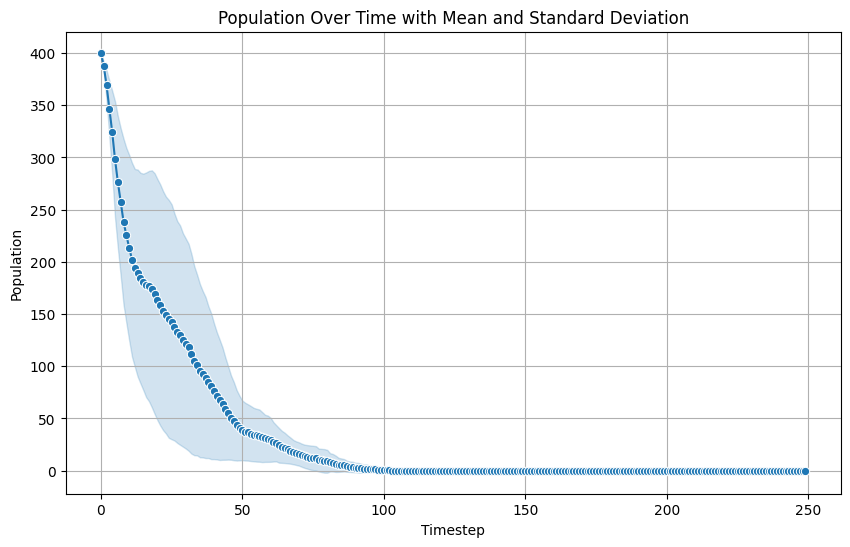

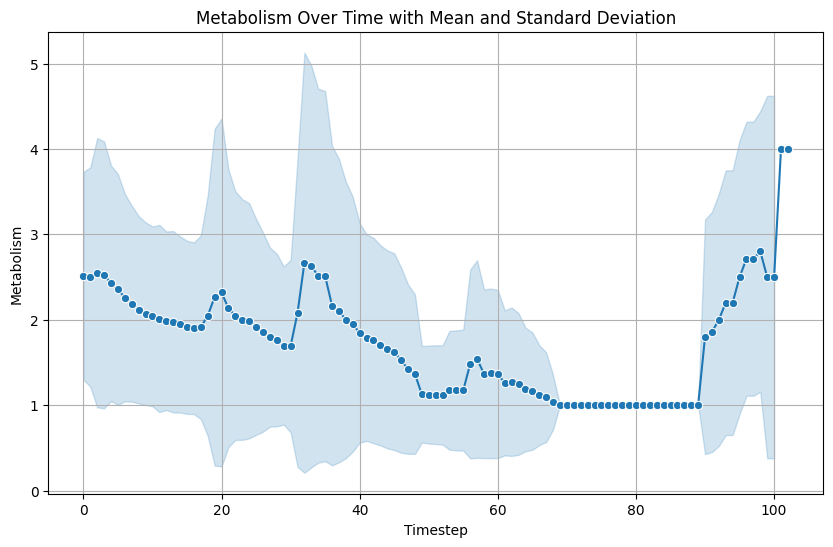

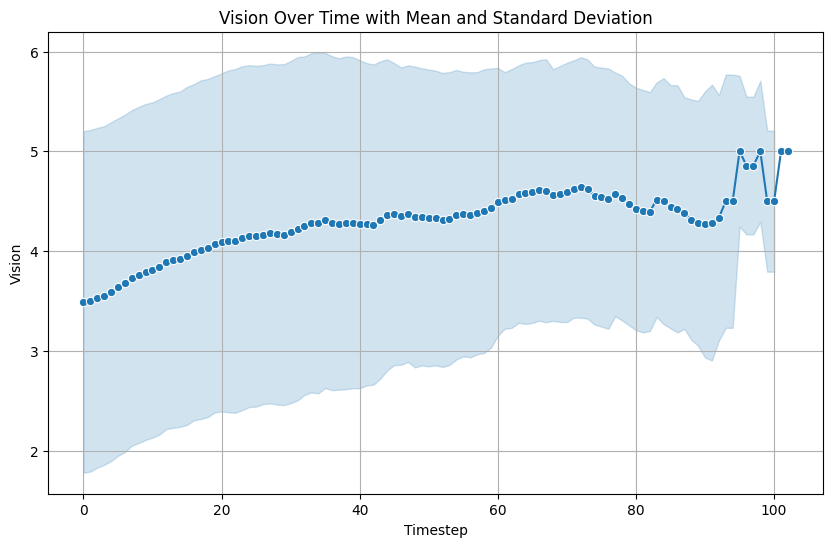

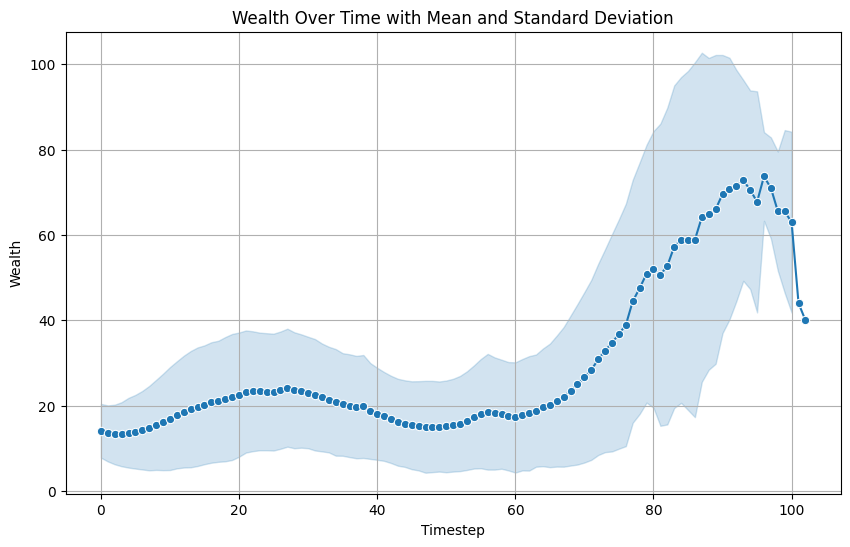

In [25]:
# Access the DataCollection instance for the chosen configuration
if config_id_to_check in data_collector.data:
    # Population Data
    population_data = data_collector.data[config_id_to_check]['population_data']
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=population_data, x='Timestep', y='Population', errorbar='sd', marker='o')
    plt.title('Population Over Time with Mean and Standard Deviation')
    plt.xlabel('Timestep')
    plt.ylabel('Population')
    plt.grid(True)
    plt.show()

    # Metabolism Data
    metabolism_data = data_collector.data[config_id_to_check]['metabolism_data']
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=metabolism_data, x='Timestep', y='Metabolism', errorbar='sd', marker='o')
    plt.title('Metabolism Over Time with Mean and Standard Deviation')
    plt.xlabel('Timestep')
    plt.ylabel('Metabolism')
    plt.grid(True)
    plt.show()

    # Vision Data
    vision_data = data_collector.data[config_id_to_check]['vision_data']
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=vision_data, x='Timestep', y='Vision', errorbar='sd', marker='o')
    plt.title('Vision Over Time with Mean and Standard Deviation')
    plt.xlabel('Timestep')
    plt.ylabel('Vision')
    plt.grid(True)
    plt.show()

    # Wealth Data
    wealth_data = data_collector.data[config_id_to_check]['wealth_data']
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=wealth_data, x='Timestep', y='Wealth', errorbar='sd', marker='o')
    plt.title('Wealth Over Time with Mean and Standard Deviation')
    plt.xlabel('Timestep')
    plt.ylabel('Wealth')
    plt.grid(True)
    plt.show()
    
    # Deaths Data
    #deaths_data = data_collector.data[config_id_to_check]['death_causes']
    #plt.figure(figsize=(10, 6))
    #sns.lineplot(data=wealth_data, x='Timestep', y='Deaths', errorbar='sd', marker='o')
    #plt.title('Deaths Over Time with Mean and Standard Deviation')
    #plt.xlabel('Timestep')
    #plt.ylabel('Deaths')
    #plt.grid(True)
    #plt.show()

else:
    print("No data available for this configuration ID.")

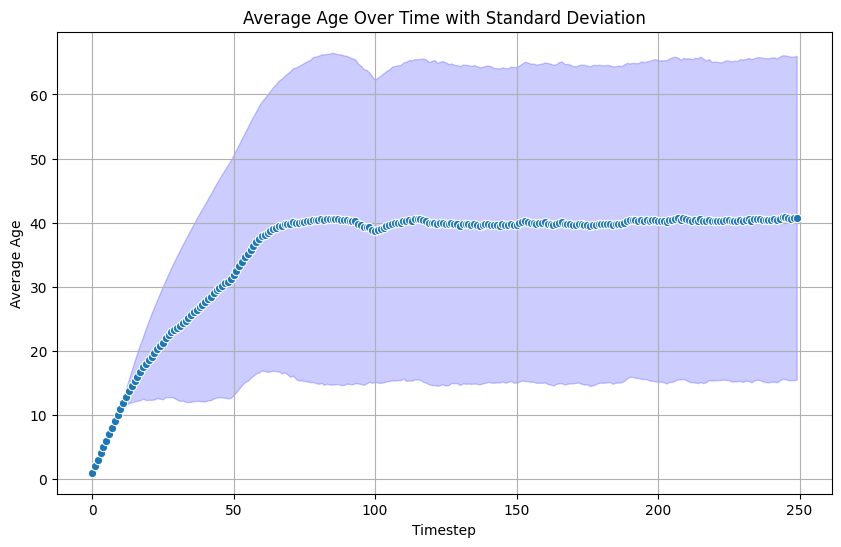

In [13]:
# Assuming 'age_distribution' is structured with columns ['Timestep', 'Age', 'Count']
age_data = data_collector.data[config_id_to_check]['age_distribution']

if not age_data.empty and age_data['Count'].sum() > 0:
    # Ensure proper data types
    age_data['Age'] = pd.to_numeric(age_data['Age'], errors='coerce')
    age_data['Count'] = pd.to_numeric(age_data['Count'], errors='coerce')
    age_data.dropna(subset=['Age', 'Count'], inplace=True)  # Drop rows where 'Age' or 'Count' could not be converted

    # Calculate the weighted age and group by Timestep
    age_data['Weighted_Age'] = age_data['Age'] * age_data['Count']
    grouped = age_data.groupby('Timestep').agg(
        Total_Count=('Count', 'sum'),
        Sum_Weighted_Age=('Weighted_Age', 'sum')
    )

    # Calculate the average age
    grouped['Average_Age'] = grouped['Sum_Weighted_Age'] / grouped['Total_Count']

    # Calculate variance for standard deviation
    age_data = age_data.merge(grouped['Average_Age'], on='Timestep')
    age_data['Variance_Term'] = age_data['Count'] * (age_data['Age'] - age_data['Average_Age'])**2
    variance_grouped = age_data.groupby('Timestep')['Variance_Term'].sum() / grouped['Total_Count']
    grouped['Std_Dev_Age'] = variance_grouped.apply(lambda x: np.sqrt(x) if x >= 0 else 0)

    # Reset index for plotting
    final_data = grouped.reset_index()

    # Plotting with standard deviation
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=final_data, x='Timestep', y='Average_Age', marker='o')
    plt.fill_between(final_data['Timestep'], final_data['Average_Age'] - final_data['Std_Dev_Age'], final_data['Average_Age'] + final_data['Std_Dev_Age'], color='blue', alpha=0.2)
    plt.title('Average Age Over Time with Standard Deviation')
    plt.xlabel('Timestep')
    plt.ylabel('Average Age')
    plt.grid(True)
    plt.show()
else:
    print("No age data available for plotting.")

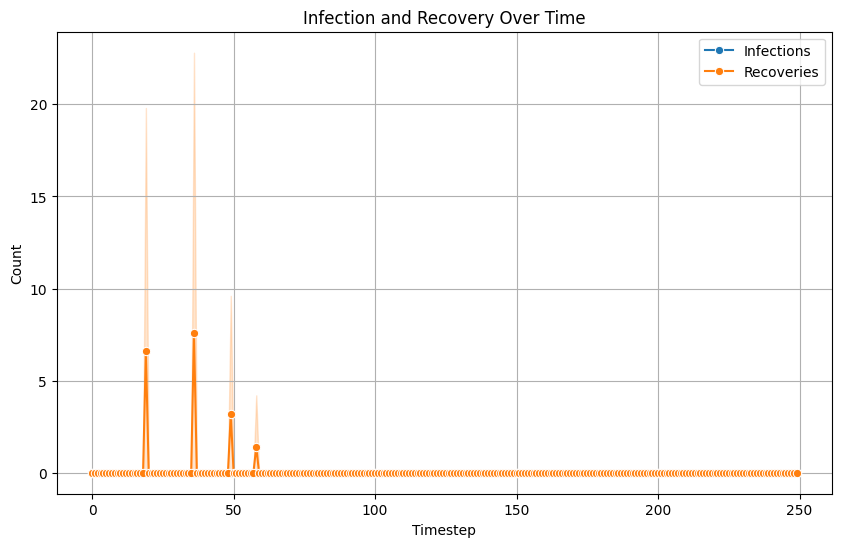

In [26]:
# Infection Data
infection_data = data_collector.data[config_id_to_check]['infection_data']

if not infection_data.empty and (infection_data['Infections'].sum() > 0 or infection_data['Recoveries'].sum() > 0):
    plt.figure(figsize=(10, 6))
    # Plotting the data
    sns.lineplot(data=infection_data, x='Timestep', y='Infections', marker='o', label='Infections')
    sns.lineplot(data=infection_data, x='Timestep', y='Recoveries', marker='o', label='Recoveries')
    plt.title('Infection and Recovery Over Time')
    plt.xlabel('Timestep')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No infection data available for plotting.")

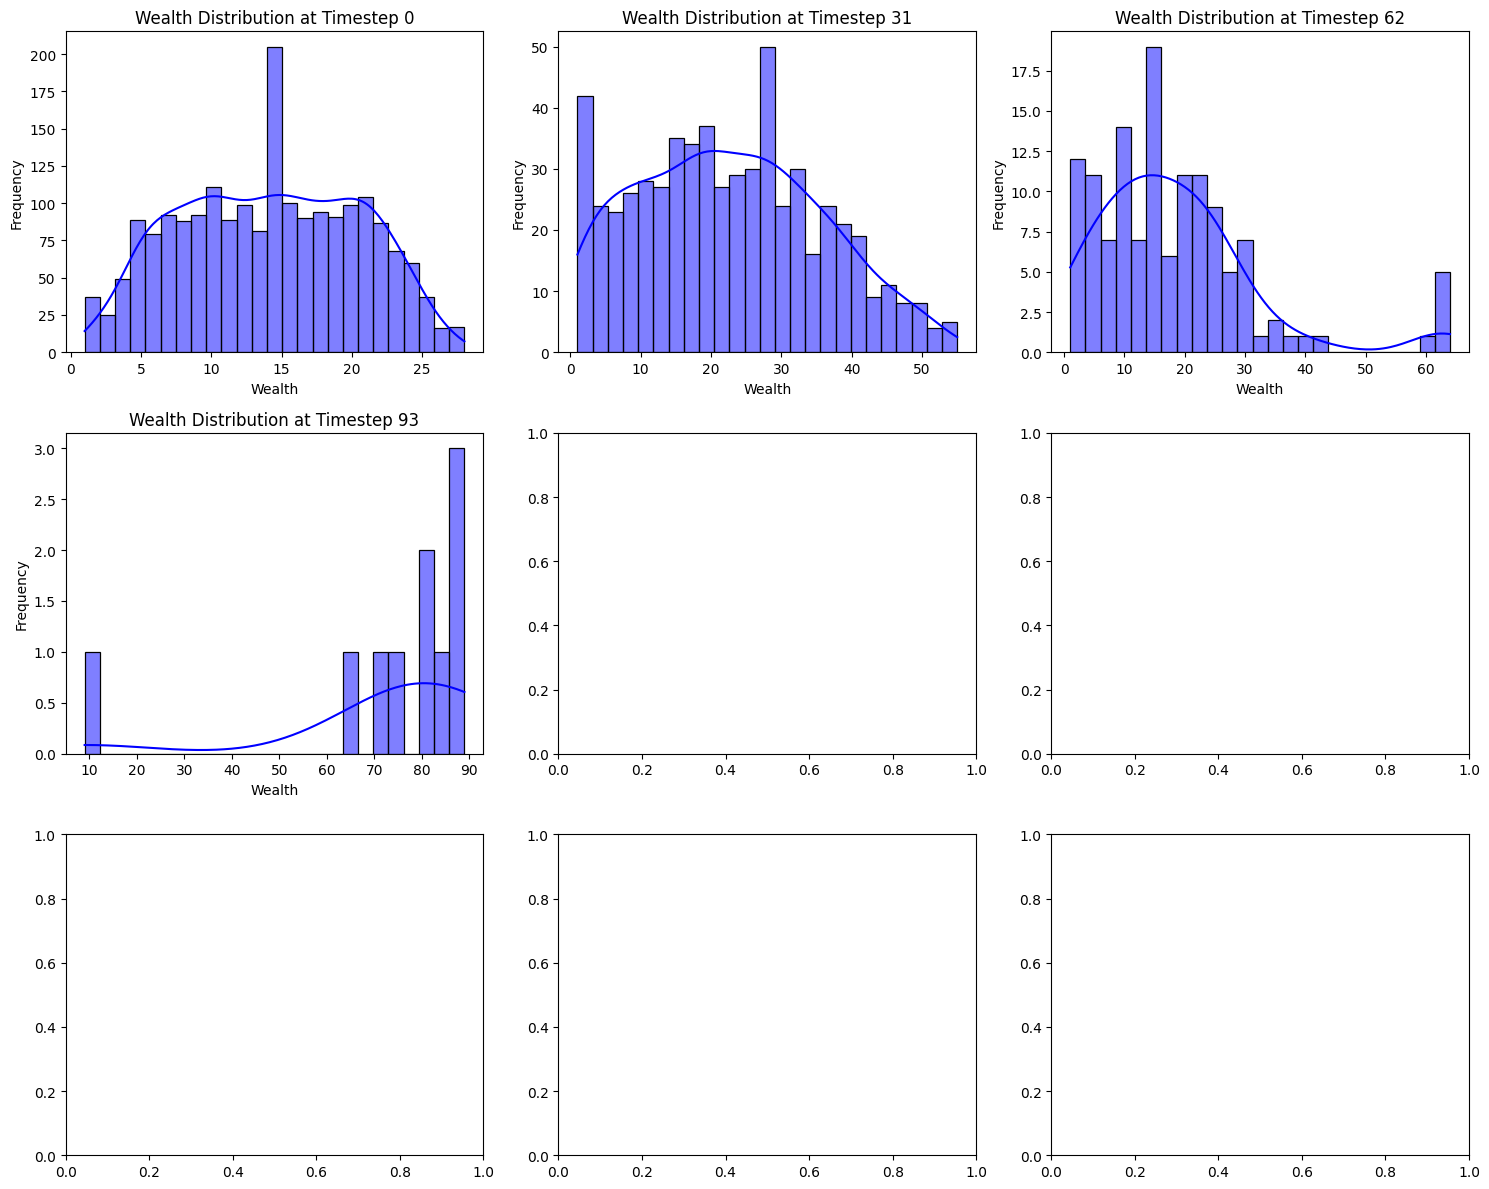

In [27]:
# Assuming you've chosen a specific configuration ID and have data available
wealth_data = data_collector.data[config_id_to_check]['wealth_data']

# Check if there's wealth data to plot
if not wealth_data.empty:
    # Define the steps you want to plot
    total_steps = wealth_data['Timestep'].max() + 1  # Assuming continuous steps from 0 to max
    step_skip = 31  # Define the number of steps to skip between plots
    steps_to_plot = range(0, total_steps, step_skip)[:9]  # Take only the first 9 steps to fit a 3x3 grid

    # Setting up the subplot grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

    # Plot histograms for each selected timestep
    for i, step in enumerate(steps_to_plot):
        # Filter the data for the current step
        data_at_step = wealth_data[wealth_data['Timestep'] == step]
        sns.histplot(data_at_step['Wealth'], ax=axes[i], kde=True, color='blue', bins=25)
        axes[i].set_title(f'Wealth Distribution at Timestep {step}')
        axes[i].set_xlabel('Wealth')
        axes[i].set_ylabel('Frequency')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
else:
    print("No wealth data available for plotting.")

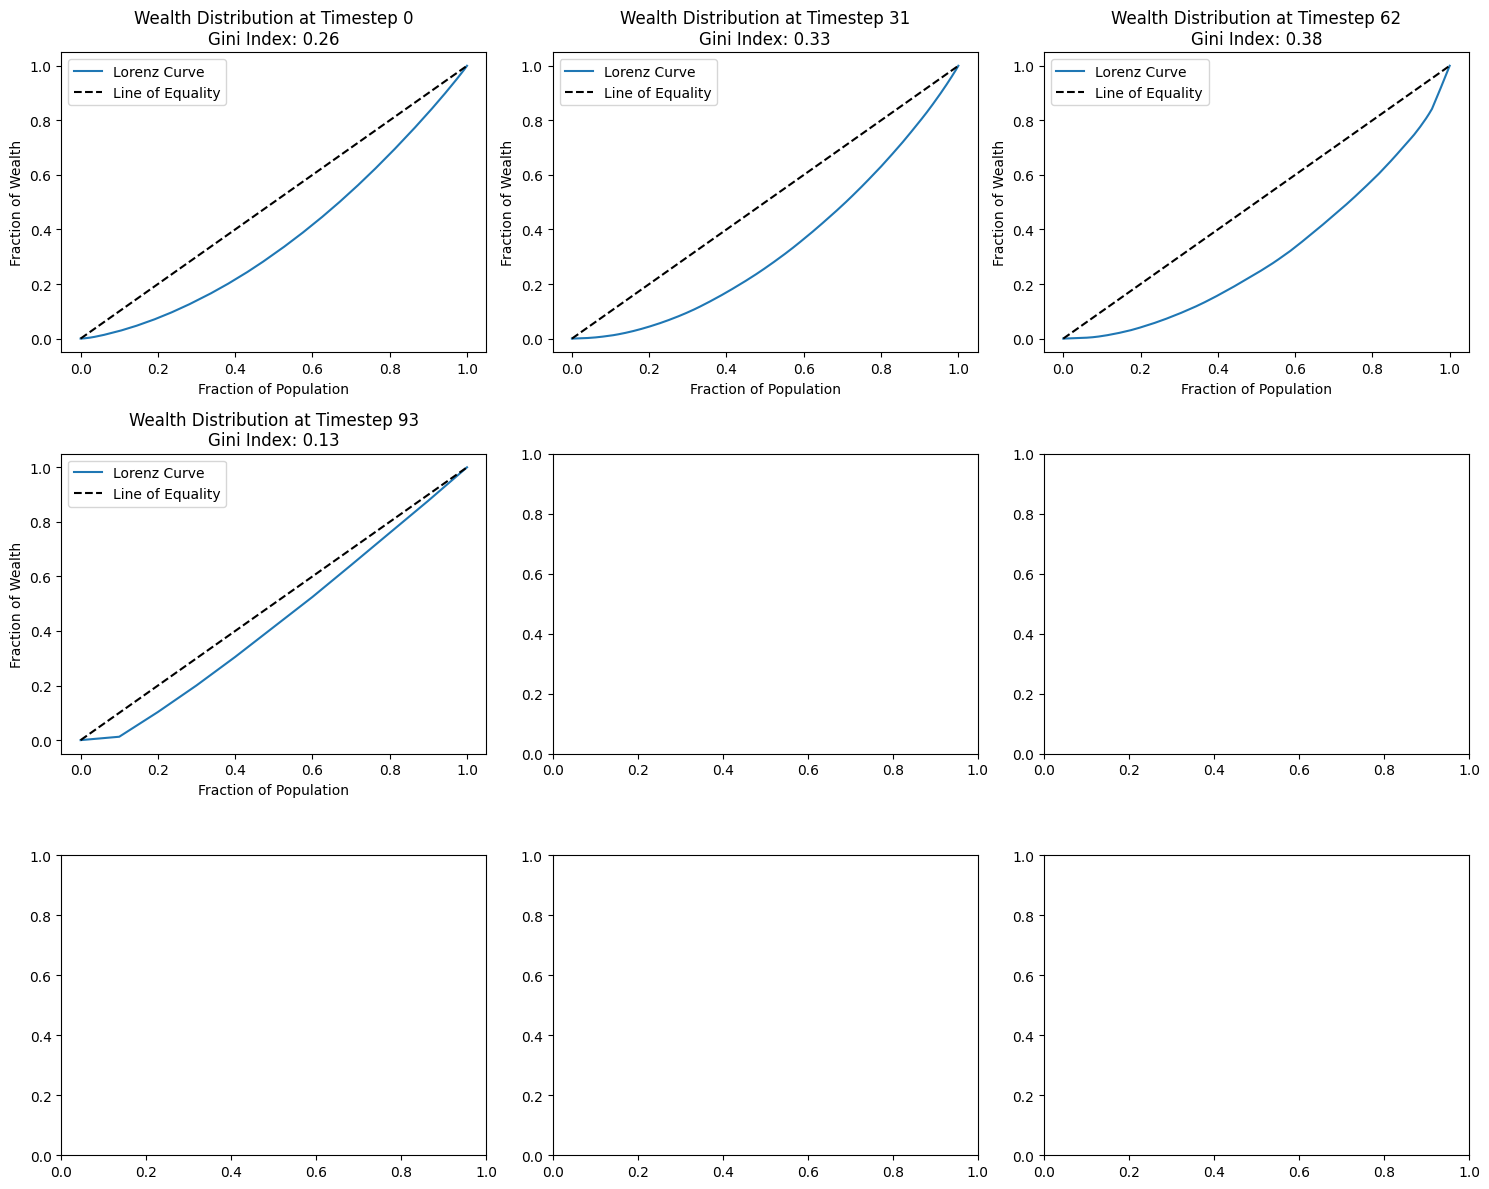

In [28]:
# Assuming you've chosen a specific configuration ID and have data available
wealth_data = data_collector.data[config_id_to_check]['wealth_data']

# Check if there's wealth data to plot
if not wealth_data.empty:
    # Define the steps you want to plot
    total_steps = wealth_data['Timestep'].max() + 1  # Assuming continuous steps from 0 to max
    step_skip = 31  # Define the number of steps to skip between plots
    steps_to_plot = range(0, total_steps, step_skip)[:9]  # Take only the first 9 steps to fit a 3x3 grid

    # Setting up the subplot grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

    # Plot Lorenz curves and calculate Gini index for each selected timestep
    for i, step in enumerate(steps_to_plot):
        # Filter the data for the current step
        data_at_step = wealth_data[wealth_data['Timestep'] == step]['Wealth']
        if data_at_step.empty:
            axes[i].text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Timestep {step}')
            continue

        # Sort data and normalize
        sorted_wealth = np.sort(data_at_step)
        cumulative_wealth = np.cumsum(sorted_wealth)
        total_wealth = cumulative_wealth[-1]
        normalized_wealth = cumulative_wealth / total_wealth

        # Create Lorenz curve points
        x = np.linspace(0, 1, len(sorted_wealth) + 1)  # Include zero point
        y = np.concatenate([[0], normalized_wealth])  # Include the zero point to start the curve

        # Plot the curve
        axes[i].plot(x, y, label='Lorenz Curve')
        axes[i].plot([0, 1], [0, 1], 'k--', label='Line of Equality')

        # Calculate and annotate Gini index
        gini_index = 1 - 2 * np.trapz(y, x)
        axes[i].set_title(f'Wealth Distribution at Timestep {step}\nGini Index: {gini_index:.2f}')
        axes[i].set_xlabel('Fraction of Population')
        axes[i].set_ylabel('Fraction of Wealth')
        axes[i].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
else:
    print("No wealth data available for plotting.")

In [29]:
def calculate_gini(arr):
    # Ensure array is sorted.
    arr = np.sort(arr)
    n = arr.size
    cumulative_sum = np.cumsum(arr)
    # Compute the Lorenz curve using the cumulative sum.
    lorenz_curve = cumulative_sum / cumulative_sum[-1]
    # Linear space to represent population share
    uniform_distribution = np.linspace(0, 1, n+1)
    # Gini index calculation using trapezoidal rule
    area_under_lorenz = np.trapz(lorenz_curve, uniform_distribution[1:])
    area_under_uniform = 0.5
    gini_index = (area_under_uniform - area_under_lorenz) / area_under_uniform
    return gini_index

# Example usage:
initial_wealth = wealth_data[wealth_data['Timestep'] == 0]['Wealth']
gini_index = calculate_gini(initial_wealth.values)
print("Gini Index at Step 0:", gini_index)

Gini Index at Step 0: 0.25734658877734273


In [30]:
np.random.seed(42)  # Ensures reproducibility

# Initialize the environment
environment = Environment(size=(50, 50), enable_seasons=True)

# Create and activate an EcoCrisis
eco_crisis = EcoCrisis(severity=0, duration=0)  # Set appropriate severity and duration
disease = Disease(severity=0, duration=0)

environment.trigger_crisis(eco_crisis)  # Trigger the EcoCrisis in the environment
environment.trigger_disease(disease)

# Randomly create and add agents ensuring unique locations
occupied_locations = set()
for _ in range(400):  # Adding 400 agents
    while True:
        location = (np.random.randint(0, 50), np.random.randint(0, 50))
        if location not in occupied_locations:
            occupied_locations.add(location)
            break
    vision = np.random.randint(1, 7)  # Vision range 1-6
    metabolism = np.random.randint(1, 5)  # Metabolism range 1-4
    sugar = np.random.randint(5, 26)  # Initial sugar range 5-25
    age = np.random.randint(60, 101)  # Initial age range 60-100
    agent = Agent(location=location, sugar=sugar, metabolism=metabolism, vision=vision, max_age=age)
    environment.add_agent(agent)

environment.capture_agents_initial_positions()

# Run the simulation for ___ steps
for step in range(250):
    environment.step()

# Initialize visualization with the environment
# Ensure that Visualization and animate_simulation are defined
visualization = Visualization(environment)

# Generate the animation
anim = visualization.animate_simulation(interval=200)

# Display the animation in a Jupyter Notebook
HTML(anim.to_jshtml())

# Optionally, save the animation as an MP4 file
anim.save('Sugarscape_seasons_animation.gif', writer='pillow')